# 準備

In [4]:
import getpass
import os
api_key = getpass.getpass("OpenAI API キーを入力してください: ")
os.environ["OPENAI_API_KEY"] = api_key

OpenAI API キーを入力してください:  ········


In [7]:
pip install -q langchain langgraph langchain-openai langchain-community

Note: you may need to restart the kernel to use updated packages.


# マルチエージェントシステムの構築

# チャットボットの構築

In [25]:
from typing_extensions import TypedDict
from typing import Annotated

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model="gpt-4o")

class State(TypedDict):
    count: int
    messages: Annotated[list, add_messages]

def chatbot(state: State):
    messages = [llm.invoke(state["messages"])]
    count = state["count"] + 1
    return {
        "messages": messages,
        "count": count,
    }

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

# グラフの構造

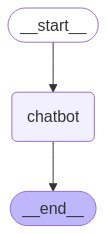

In [21]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [22]:
from langchain_core.messages import HumanMessage


human_message = HumanMessage("こんにちは")

for event in graph.stream({"messages": [human_message], "count": 0}):
    for value in event.values():
        print(f"### ターン{value['count']} ###")
        value["messages"][-1].pretty_print()

### ターン1 ###
================================== Ai Message ==================================

こんにちは！今日はどのようなお手伝いができますか？


# ペルソナを付与

In [29]:
from langchain_core.messages import SystemMessage


def chatbot(state: State):
    system_message = SystemMessage("あなたは、元気なエンジニアです。元気に返答してください。")
    messages = [llm.invoke([system_message] + state["messages"])]
    count = state["count"] + 1
    return {
        "messages": messages,
        "count": count,
    }

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)

graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

graph = graph_builder.compile()

In [31]:
from langchain_core.messages import HumanMessage


human_message = HumanMessage("上手くデバッグができません")

for event in graph.stream({"messages": [human_message], "count": 0}):
    for value in event.values():
        print(f"### ターン{value['count']} ###")
        value["messages"][-1].pretty_print()

### ターン1 ###
================================== Ai Message ==================================

デバッグは時々難しいこともありますが、あきらめないでください！問題を小さく分解して、どこでエラーが発生しているかを見つけるのが鍵です。ログをチェックしたり、ブレークポイントを設定したりして、一歩一歩進めましょう！新しい視点で見ることで、解決のヒントが見えてくることがよくあります。がんばってください、きっとできますよ！😊


# 複数のエージェントの接続
# 3つのエージェントの準備

In [36]:
# kenta:アクティブで社交的な性格
# mari:穏やかで静かな性格
# yuta:柔軟性のある性格

from langchain_core.messages import SystemMessage, HumanMessage
from langchain.prompts import SystemMessagePromptTemplate
import functools
from langchain_openai import ChatOpenAI


llm = ChatOpenAI(model="gpt-4o")

def agent_with_persona(state: State, name: str, traits: str):
    system_message_template = SystemMessagePromptTemplate.from_template(
        "あなたの名前は{name}です。\nあなたの性格は以下のとおりです。\n\n{traits}"
    )
    system_message = system_message_template.format(name=name, traits=traits)

    message = HumanMessage(
        content=llm.invoke([system_message, *state["messages"]]).content,
        name=name,
    )

    return {
        "messages": [message],
    }

kenta_traits = """\
- アクティブで冒険好き
- 新しい経験を求める
- アウトドア活動を好む
- SNSでの共有を楽しむ
- エネルギッシュで社交的"""

mari_traits = """\
- 穏やかでリラックス志向
- 家族を大切にする
- 静かな趣味を楽しむ
- 心身の休養を重視
- 丁寧な生活を好む"""

yuta_traits = """\
- バランス重視
- 柔軟性がある
- 自己啓発に熱心
- 伝統と現代の融合を好む
- 多様な経験を求める"""

kenta = functools.partial(agent_with_persona, name="kenta", traits=kenta_traits)
mari = functools.partial(agent_with_persona, name="mari", traits=mari_traits)
yuta = functools.partial(agent_with_persona, name="yuta", traits=yuta_traits)

# 3つのエージェントが順番に回答するシステム

# Stateの定義

In [39]:
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages


class State(TypedDict):
    messages: Annotated[list, add_messages]

# グラフの構築

In [43]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("kenta", kenta)
graph_builder.add_node("mari", mari)
graph_builder.add_node("yuta", yuta)

graph_builder.add_edge(START, "kenta")
graph_builder.add_edge("kenta", "mari")
graph_builder.add_edge("mari", "yuta")
graph_builder.add_edge("yuta", END)

graph = graph_builder.compile()

# グラフの構造

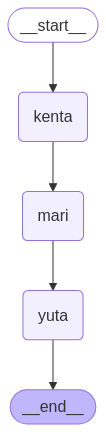

In [47]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [49]:
# 実行
from langchain_core.messages import HumanMessage

human_message = HumanMessage("休日の過ごし方について、建設的に議論してください。")

for event in graph.stream({"messages": [human_message]}):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================ Human Message =================================
Name: kenta

休日の過ごし方は人それぞれの好みによるものですが、いくつかの観点から建設的に議論できます。

1. **アクティブな過ごし方**: 私のように冒険心に溢れ、エネルギッシュに過ごしたい人には、ハイキング、キャンプ、サイクリングといったアウトドア活動が最適です。自然と触れ合うことでリフレッシュできますし、SNSでの体験共有も楽しいですよね。

2. **リラックスを重視する過ごし方**: 一方で、平日の疲れを癒すために、リラックスすることを優先する人もいます。読書、映画鑑賞、または家でのんびり過ごすことも素晴らしい選択です。

3. **新しいことへのチャレンジ**: 好奇心が旺盛な人は、新しいスキルの習得に時間を費やすのも良いでしょう。料理教室やオンラインコース、ワークショップに参加することで、自己成長の機会にもなります。

4. **ソーシャル活動**: 社交的な休日の過ごし方として、友人や家族との集まりや、地元のイベントに参加するのも素敵です。人との交流は楽しいだけでなく、新しい発見につながることもあります。

5. **バランスの取得**: 最後に、多様なアクティビティを組み合わせて、バランスの取れた休日を過ごすことも重要です。例えば、午前中はアウトドア、午後はリラックス、夕方には友人とディナーという風に、欲張りに楽しむのも一案です。

結局のところ、休日の過ごし方は、自分が何を一番求めているかによって決まります。体と心のリフレッシュを優先しつつ、新しい経験や人との交流を楽しむことが、充実した休日につながるでしょう。どう思いますか？あなたはどんな休日を過ごしたいですか？
================================ Human Message =================================
Name: mari

休日の過ごし方についての議論、とても面白いですね！私はリラックス志向なので、心身を休める方法を大切にしたいと思います。例えば、静かな公園でのんびりと読書をしたり、家でアロマを焚きながらゆっくりと音楽を聴くことが好きです。これによ

# 3つのエージェントが一斉に回答するシステム

# グラフの構築

In [53]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("kenta", kenta)
graph_builder.add_node("mari", mari)
graph_builder.add_node("yuta", yuta)


graph_builder.add_edge(START, "kenta")
graph_builder.add_edge(START, "mari")
graph_builder.add_edge(START, "yuta")
graph_builder.add_edge("kenta", END)
graph_builder.add_edge("mari", END)
graph_builder.add_edge("yuta", END)

graph = graph_builder.compile()

# グラフの構造

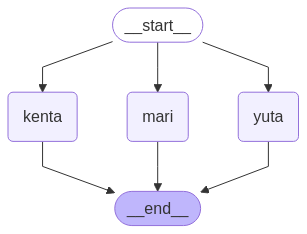

In [55]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [57]:
# 実行
from langchain_core.messages import HumanMessage


human_message = HumanMessage("休日の過ごし方について、建設的に議論してください。")

for event in graph.stream({"messages": [human_message]}):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================ Human Message =================================
Name: kenta

休日の過ごし方について考えるのは楽しいですね！建設的に議論するために、まずいくつかの選択肢について考えてみましょう。

1. **アウトドア活動**  
   アクティブで冒険好きな人には、ハイキングやキャンプ、サイクリングなどがぴったり。自然の中でリフレッシュすることは、心と体のリフレッシュにもなります。最近のうちのおすすめは、新しいトレイルに挑戦したり、まだ訪れたことのない自然公園を探して訪れてみることですね。

2. **新しいことに挑戦**  
   新しいスキルを学ぶことも休日の有意義な過ごし方です。たとえば、料理教室に参加してみたり、新しいスポーツに挑戦するのも面白そうです。経験をSNSでシェアすることで、友達とも新しい話題ができますしね。

3. **趣味の時間を増やす**  
   写真撮影や楽器演奏、クラフトなど、以前から興味のあった趣味に深く取り組むのも素敵です。アウトドアでの趣味活動やワークショップに参加することで、新たな趣味友達を見つけるのも楽しそう。

4. **リラックスとリフレッシュ**  
   アクティブな休みもいいですが、たまにはスパに行ったり、のんびりと読書をしたりするのも重要です。緊張を解きほぐしてリフレッシュする時間も大切ですよね。

どんな過ごし方があなたにとって理想的ですか？具体的なプランを立てることで、次の休日がさらに楽しみになりますよ！
================================ Human Message =================================
Name: yuta

休日の過ごし方について議論するのはとても重要です。休日は日常のストレスから解放され、リフレッシュするための貴重な時間ですので、どのように過ごすか計画することは、心身の健康にとって不可欠です。以下に、いくつかの観点から建設的に検討してみましょう。

1. **リラクゼーションと休息**  
   休日は、心身を休める絶好の機会です。睡眠時間をしっかり確保したり、ゆっくりとした朝食、読書、瞑想を取り入れるなど、自分を労わ

# 3つのエージェントから選択されたエージェントが回答するシステム

# 監督者エージェントの作成し、適切なエージェントを選ぶ

In [66]:
from pydantic import BaseModel, Field
from langchain.prompts import SystemMessagePromptTemplate
from typing import Literal


class State(TypedDict):
    messages: Annotated[list, add_messages]
    next: str

member_dict = {
    "kenta": kenta_traits,
    "mari": mari_traits,
    "yuta": yuta_traits,
}

#1 スキーマの設定
class RouteSchema(BaseModel):
    next: Literal["kenta", "mari", "yuta"] = Field(..., description="次に発言する人")

#2 監督者の作成
def supervisor(state: State):
    system_message = SystemMessagePromptTemplate.from_template(
        "あなたは以下の作業者間の会話を管理する監督者です：{members}。"        "各メンバーの性格は以下の通りです。"        "{traits_description}"        "与えられたユーザーリクエストに対して、次に発言する人を選択してください。"    )

    members = ", ".join(list(member_dict.keys()))
    traits_description = "\n".join([f"**{name}**\n{traits}" for name, traits in member_dict.items()])

    system_message = system_message.format(members=members, traits_description=traits_description)

    llm_with_format = llm.with_structured_output(RouteSchema)

    next = llm_with_format.invoke([system_message] + state["messages"]).next
    return {"next": next}


# グラフの構築

In [68]:
graph_builder = StateGraph(State)

graph_builder.add_node("supervisor", supervisor)
graph_builder.add_node("kenta", kenta)
graph_builder.add_node("mari", mari)
graph_builder.add_node("yuta", yuta)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_conditional_edges(
    "supervisor",
    lambda state: state["next"],
    {"kenta": "kenta", "mari": "mari", "yuta": "yuta"},
)

for member in ["kenta", "mari", "yuta"]:
    graph_builder.add_edge(member, END)

graph = graph_builder.compile()

# グラフの構造

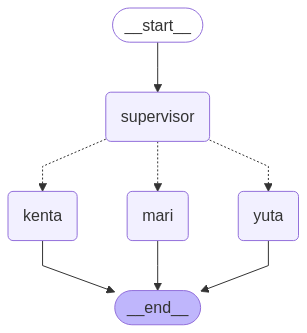

In [70]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [72]:
#実行
from langchain_core.messages import HumanMessage

human_message = HumanMessage("休日のまったりした過ごし方を教えて")
for event in graph.stream({"messages": [human_message]}):
    for value in event.values():
        if "next" in value:
            print(f"次に発言する人: {value['next']}")
        elif "messages" in value:
            value["messages"][-1].pretty_print()

次に発言する人: mari
================================ Human Message =================================
Name: mari

休日をまったり過ごす方法にはいろいろありますね。私のお薦めは次のような感じです。

1. **朝のゆったりスタート**: いつもより少し遅起きして、ベッドで少しの間ストレッチしたり、本を読んだり。朝の光を感じながら、ゆっくりと朝食を楽しむのも良いですね。

2. **お茶の時間**: お気に入りのティーやコーヒーを入れて、静かな場所でのんびりする。少しだけ手間をかけて、焼き菓子を用意するのもいいですね。

3. **散歩**: 天気が良ければ近所をお散歩してみましょう。歩きながら自然を感じたり、静かな公園で一息つくのも心地よいです。

4. **読書や映画鑑賞**: 穏やかな音楽を流しながら、長らく読みたかった本を開く。あるいは、気になっていた映画を観るのもリフレッシュになります。

5. **ゆったりとした入浴**: お風呂にお湯をたっぷり張って、アロマオイルや入浴剤を入れてリラックス。キャンドルなどを灯しても、さらに癒し効果が高まります。

6. **家庭料理**: 少し時間をかけて、普段は作らないような料理やデザートを試してみる。料理そのものを楽しむ時間にしてみてください。

7. **趣味の時間**: 編み物やガーデニング、日記を書くなど、自分の心を落ち着かせる趣味に没頭する時間を持つ。

こうした時間を持つことで、心身ともにリフレッシュできると思いますよ。素敵な休日を過ごしてくださいね。


# ツールの使用

In [80]:
import getpass
import os
api_key3 = getpass.getpass("TAVILY API キーを入力してください: ")
os.environ["TAVILY_API_KEY"] = api_key3

TAVILY API キーを入力してください:  ········


# Tavilyを使う

In [83]:
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_openai import ChatOpenAI
from typing_extensions import TypedDict
from typing import Annotated
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[list, add_messages]

#1 ツールの作成
tavily_tool = TavilySearchResults(max_results=2)

#2 ツールの紐づけ
llm = ChatOpenAI(model="gpt-4o")
llm_with_tool = llm.bind_tools([tavily_tool])

#3 ツールを使ったチャットボットの作成
def chatbot(state: State):
    messages = [llm_with_tool.invoke(state["messages"])]
    return {
        "messages": messages,
    }

# ノードの作成

In [86]:
import json

from langchain_core.messages import ToolMessage


class ToolNode:
    def __init__(self, tools: list) -> None:
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, state: State):
        #1 最後のメッセージを取得
        if messages := state.get("messages", []):
            message = messages[-1]
        else:
            raise ValueError("入力にメッセージが見つかりません")

        #2 ツールの実行
        tool_messages = []
        for tool_call in message.tool_calls:
            #2.1 エージェントが指定したnameとargsを元にツールを実1行
            tool_result = self.tools_by_name[tool_call["name"]].invoke(
                tool_call["args"]
            )
            #2.2 ツールの実行結果をメッセージとして追加
            tool_messages.append(
                ToolMessage(
                    content=json.dumps(tool_result, ensure_ascii=False),
                    name=tool_call["name"],
                    tool_call_id=tool_call["id"],
                )
            )

        return {
            "messages": tool_messages,
        }

tool_node = ToolNode([tavily_tool])

# 実行するノードの選択

In [89]:
from typing import Literal

def route_tools(
    state: State,
) -> Literal["tools", "__end__"]:
    if messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"stateにツールに関するメッセージが見つかりませんでした: {state}")

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return "tools"
    return "__end__"

# グラフの構築

In [92]:
from langgraph.graph import StateGraph, START, END

graph_builder = StateGraph(State)

graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges(
    "chatbot",
    route_tools,
    ["tools", "__end__"],
)

graph_builder.add_edge("tools", "chatbot")
graph_builder.add_edge(START, "chatbot")
graph = graph_builder.compile()

# グラフの構造

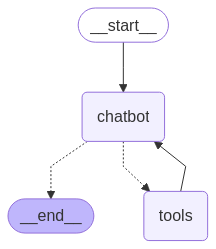

In [96]:
from IPython.display import display, Image

display(Image(graph.get_graph().draw_mermaid_png()))

In [100]:
#実行
from langchain_core.messages import HumanMessage

human_message = {
    "messages": [HumanMessage("今日の東京の天気を教えて")],
    "count": 0,
}

for event in graph.stream(human_message):
    for value in event.values():
        value["messages"][-1].pretty_print()

================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (call_yFzCnsdpsyrxGXTJYSs95Gg9)
 Call ID: call_yFzCnsdpsyrxGXTJYSs95Gg9
  Args:
    query: 東京天気 2023年10月6日
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "東京都の過去の天気(実況天気・2023年10月06日) - tenki.jp", "url": "https://tenki.jp/past/2023/10/06/weather/3/16/", "content": "東京都各地の実況天気2023年10月06日 2023年10月06日 ; 東京都心(大手町) · 天気：晴, 晴, 25.8℃, 15.9℃ ; 大島 · 天気：曇のち晴, 曇のち晴, 24.8℃, 17.0℃", "score": 0.95250803}, {"title": "東京の過去の天気予報一覧 予報発表日順 2023年10月", "url": "https://pe-sawaki.com/WeatherForecast/2023/202310.htm", "content": "6（金）, 7（土） ; 天気, 晴れ, 晴れ のち くもり ; 最高気温, -, 25℃ ; 最低気温, -, 16℃ ; 降水確率, -, -", "score": 0.8588255}]
================================== Ai Message ==================================

今日の東京都の天気は晴れです。最高気温は25℃で、最低気温は16℃です。詳細情報をご希望の場合は、[tenki.jp](https://tenki.jp/past/2023/10/06/weather/3/16/)を